
# Bagging Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


+ basic sklearn calls
+ show that addition of a strong feature might degrade performance due to the trees geeting correlated


In [1]:
import numpy as np
import pylab as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
Dp0=pd.read_csv('../datasets/S_MPOS_27_100',delimiter=" ",header=None)
Dn0=pd.read_csv('../datasets/S_MNEG_27_100',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))

X=D.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

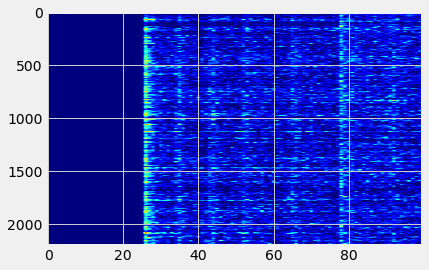

In [3]:
plt.imshow(X,aspect='auto',cmap='jet');

In [4]:
clf_ = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf_,n_estimators=1000,oob_score=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"% (y_test.shape[0],(y_test != y_pred).sum()))

acc=clf.score(X_test,y_test)
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
auc=metrics.auc(fpr, tpr)

print(acc,auc,clf.oob_score_)

Number of mislabeled points out of a total 1102 points : 578
0.47549909255898365 0.5513456378567363 0.4786557674841054


In [5]:
clf.estimators_[:5]

[DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=95629804),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1009489552),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=498588228),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=11029329),
 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                        random_state=1103937622)]

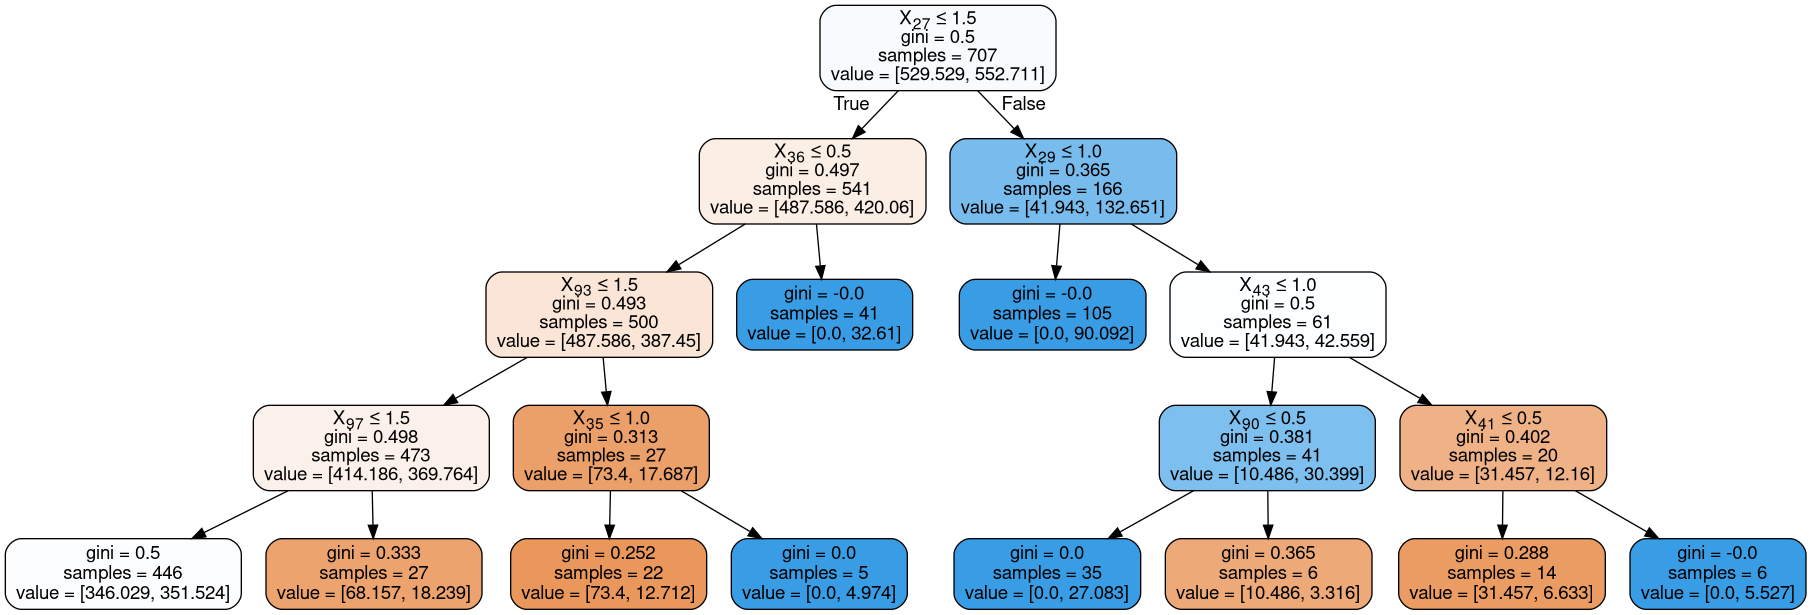

In [7]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

count=3
dot_data = StringIO()
export_graphviz(clf.estimators_[count], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
#export_graphviz(clf.estimators_[count], out_file='bagging_tree'+str(count)+'.dot',
#                filled=True, rounded=True,
#                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=1900, unconfined=True)

#call(['dot', '-Tpng', 'bagging_tree'+str(count)+'.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])


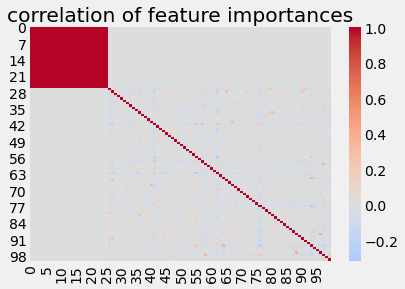

In [8]:
FI={}
count=0
for i in clf.estimators_:
    FI[count]=i.feature_importances_
    count=count+1
FI=pd.DataFrame(FI)
cFI=np.corrcoef(FI.fillna(0).values+0.00001)
ax=sns.heatmap(cFI,cmap='coolwarm',center=0)
ax.set_title('correlation of feature importances');

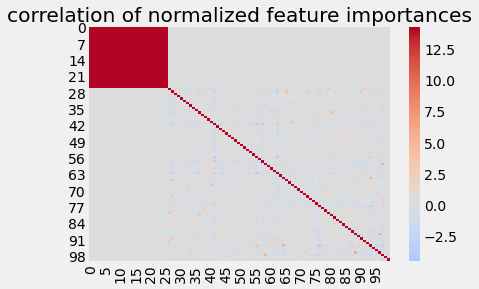

In [9]:
cFI_=pd.DataFrame(cFI).fillna(0)
cFI_.mean().mean()
ax=sns.heatmap(cFI_/cFI_.mean().mean(),cmap='coolwarm',center=0)
ax.set_title('correlation of normalized feature importances');

In [10]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    clf_ = DecisionTreeClassifier(max_depth=7, class_weight='balanced')
    clf = BaggingClassifier(base_estimator=clf_,n_estimators=40,oob_score=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


Text(0.5, 1.0, 'AUC')

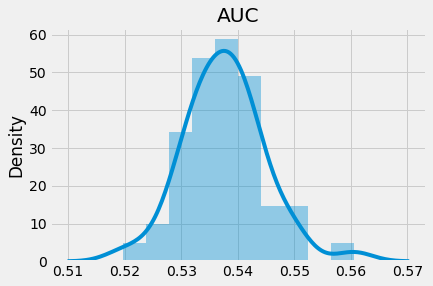

In [11]:
#auc
ax=sns.distplot(P[:,1])
ax.set_title('AUC')

Text(0.5, 1.0, 'accuracy')

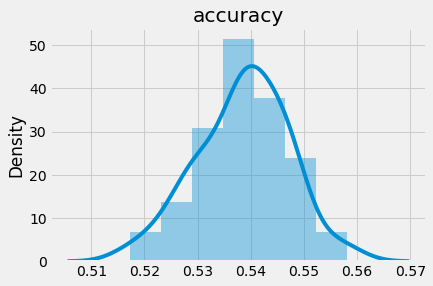

In [12]:
#acc
ax=sns.distplot(P[:,0])
ax.set_title('accuracy')

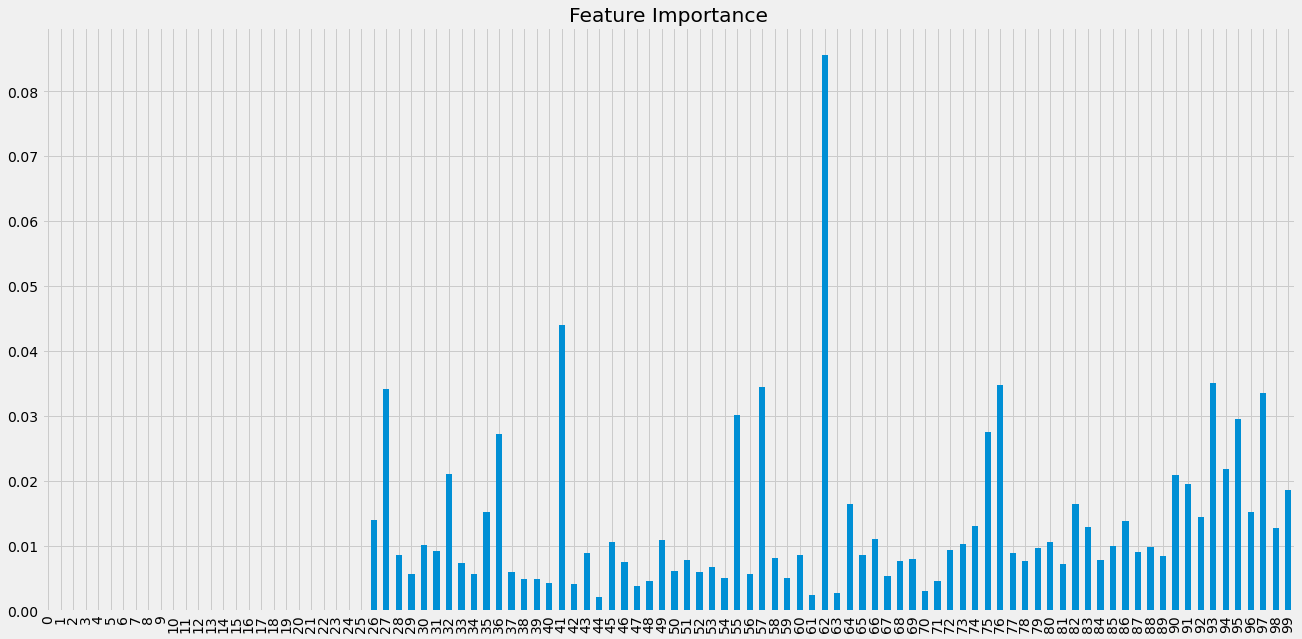

In [13]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
ax=pd.DataFrame(FI).mean(axis=1).plot(kind='bar')
ax.set_title('Feature Importance');

# Investigate correlation problem in bagging classifiers

In [14]:
Dp0=pd.read_csv('../datasets/S_MPOS_27_100',delimiter=" ",header=None)
Dn0=pd.read_csv('../datasets/S_MNEG_27_100',delimiter=" ",header=None)

Dp0s=Dp0
Dn0s=Dn0.sample(Dp0s.index.size)
Dn0s=Dn0.sample(2000)


D=pd.concat([Dp0s,Dn0s])
y=np.append(np.zeros([Dp0s.index.size,1]),np.ones([Dn0s.index.size,1]))

# Add a strong feature

In [35]:
D['strong_feature']=np.random.normal(-.1, .1, y.shape)+y*.01

X=D.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [37]:
clf_ = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf_,n_estimators=10,oob_score=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"% (y_test.shape[0],(y_test != y_pred).sum()))

acc=clf.score(X_test,y_test)
y_pred=clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
auc=metrics.auc(fpr, tpr)

print(acc,auc,clf.oob_score_)

Number of mislabeled points out of a total 1102 points : 288
0.7386569872958257 0.5669610778443114 0.7120799273387829


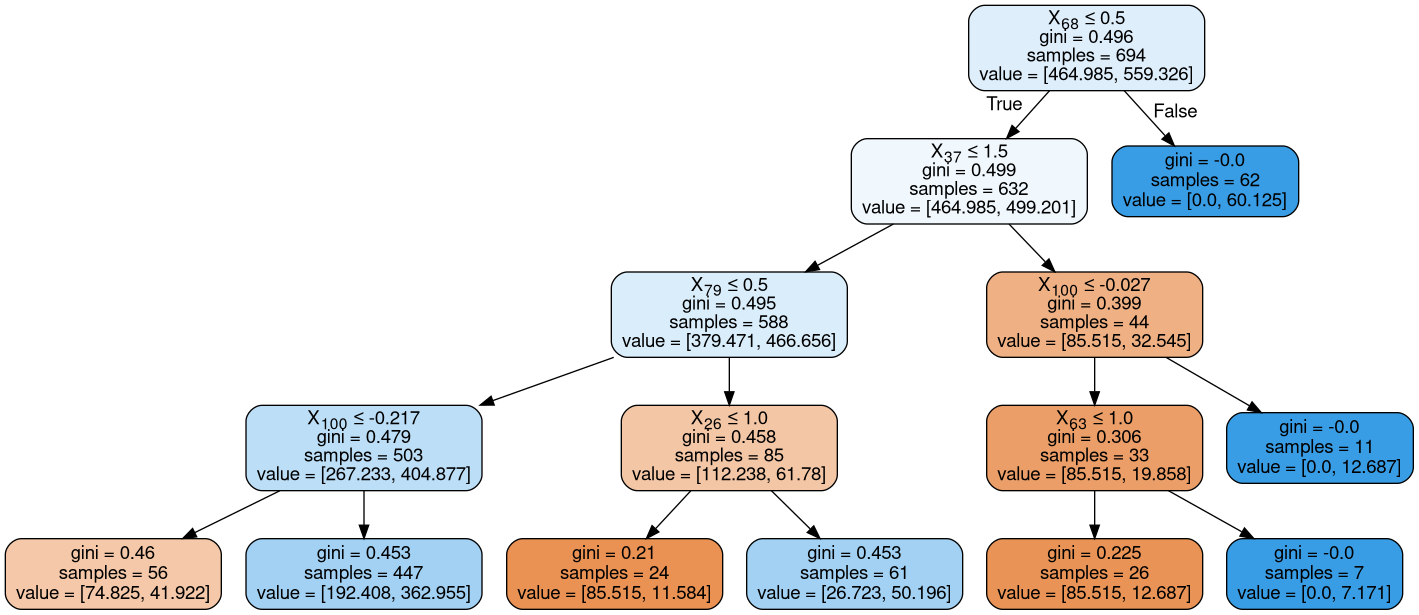

In [43]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from subprocess import call

count=1
dot_data = StringIO()
export_graphviz(clf.estimators_[count], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
#export_graphviz(clf.estimators_[count], out_file='bagging_tree'+str(count)+'.dot',
#                filled=True, rounded=True,
#                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=1900, unconfined=True)

#call(['dot', '-Tpng', 'bagging_tree'+str(count)+'.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])


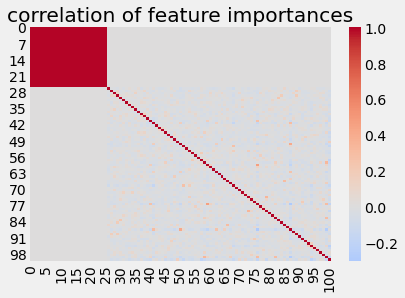

In [18]:
FI={}
count=0
for i in clf.estimators_:
    FI[count]=i.feature_importances_
    count=count+1
FI=pd.DataFrame(FI)
cFI=np.corrcoef(FI.fillna(0).values+0.00001)
ax=sns.heatmap(cFI,cmap='coolwarm',center=0,vmin=-.3,vmax=1)
ax.set_title('correlation of feature importances');

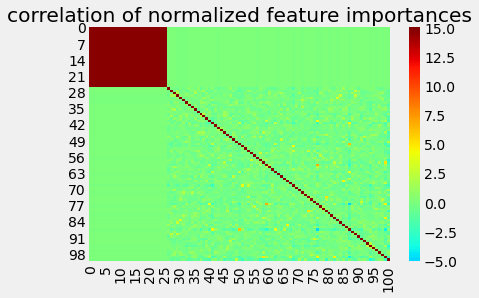

In [19]:
cFI_=pd.DataFrame(cFI).fillna(0)
cFI_.mean().mean()
ax=sns.heatmap(cFI_/cFI_.mean().mean(),cmap='jet',center=0,vmin=-5,vmax=15)
ax.set_title('correlation of normalized feature importances');

In [20]:
# check how much the performance varies by random splits (variance)
RUNS=50
P=[]
for run in tqdm(np.arange(RUNS)):
    clf_ = DecisionTreeClassifier(max_depth=7, class_weight='balanced')
    clf = BaggingClassifier(base_estimator=clf_,n_estimators=40,oob_score=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    acc=clf.score(X_test,y_test)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    auc=metrics.auc(fpr, tpr)
    P=np.append(P,[acc,auc])
P=P.reshape(int(len(P)/2),2)

100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Text(0.5, 1.0, 'AUC')

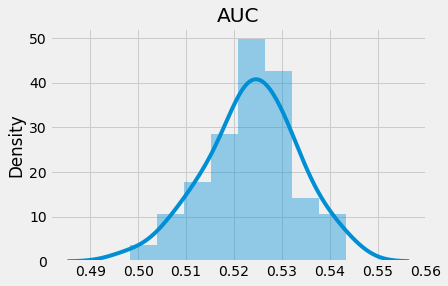

In [88]:
#auc
ax=sns.distplot(P[:,1])
ax.set_title('AUC')

Text(0.5, 1.0, 'accuracy')

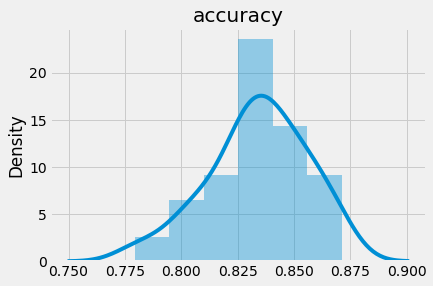

In [89]:
#acc
ax=sns.distplot(P[:,0])
ax.set_title('accuracy')

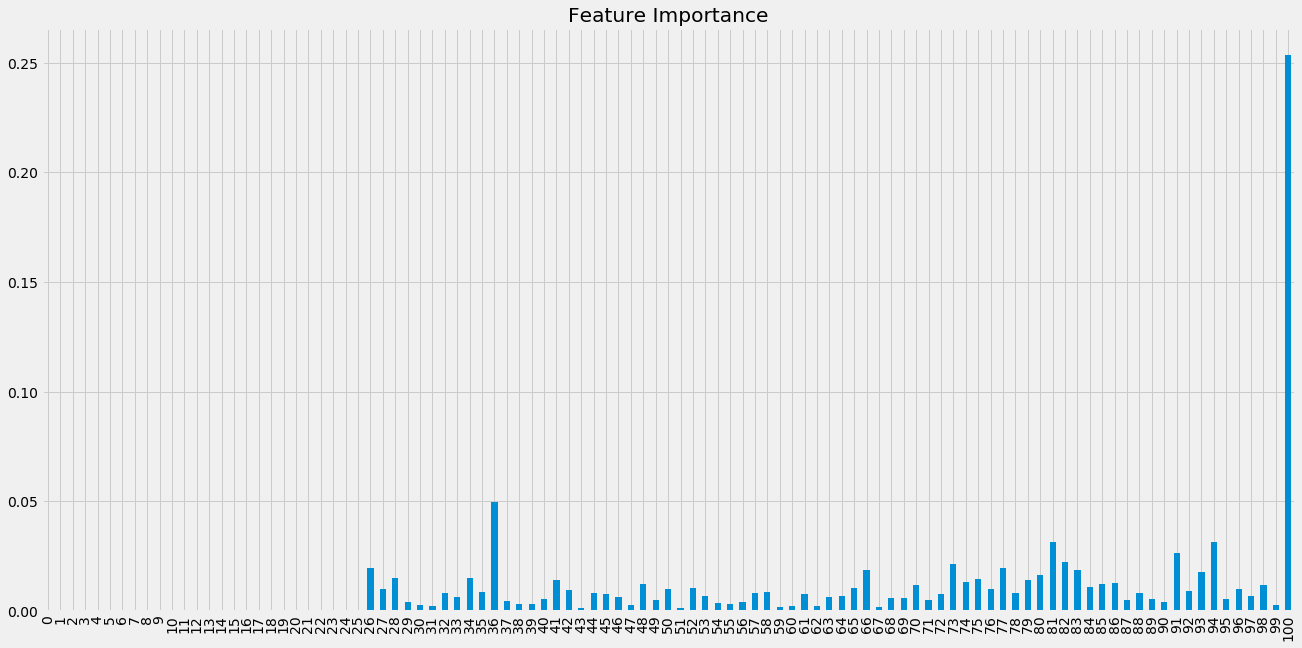

In [90]:
# compute feature importance
plt.figure(figsize=[20,10])
FI={}
count=0
for i in clf.estimators_:
    FI[count]=np.array(i.feature_importances_)
    count=count+1
#FI=FI/len(clf.estimators_)
ax=pd.DataFrame(FI).mean(axis=1).plot(kind='bar')
ax.set_title('Feature Importance');